# Recurrent Neural Network Assignment
## Gabriel Marcelino, Grant Burk, Eli   
## CST-435
**October 30, 2024**  


## Problem Statement
Goal is to develop a neural network model capable of predicting the next word in a sentence based on a given sequence of words. This model should use a recurrent neural network (RNN), specifically an LSTM architecture, to understand the sequential context of text data. By training on a large corpus of text, the model will be able to suggest the most likely word to follow a given input sequence.

## 1. Import Requirements and Load data


In [2]:
import kagglehub
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
import random
from nltk.tokenize import sent_tokenize
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

path = kagglehub.dataset_download("mikeortman/wikipedia-sentences")
nltk.download('punkt_tab')

print("Path to dataset files:", path)

# List files in the dataset directory
files = os.listdir(path)
print("Files in dataset:", files)

# Select a subset of files (e.g., first 10 files)
subset_files = files[:10]
print("Subset of files:", subset_files)

# Load and process the subset of files
data = ""
for file in subset_files:
    with open(os.path.join(path, file), 'r', encoding='utf-8') as f:
        data += f.read()

print("Loaded data from subset of files")

# Taking too long to run -> Use only the first 100,000 characters for testing
data = data[:8000000]

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/gabriel/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Path to dataset files: /Users/gabriel/.cache/kagglehub/datasets/mikeortman/wikipedia-sentences/versions/3
Files in dataset: ['wikisent2.txt']
Subset of files: ['wikisent2.txt']
Loaded data from subset of files


## 2. Visualize data

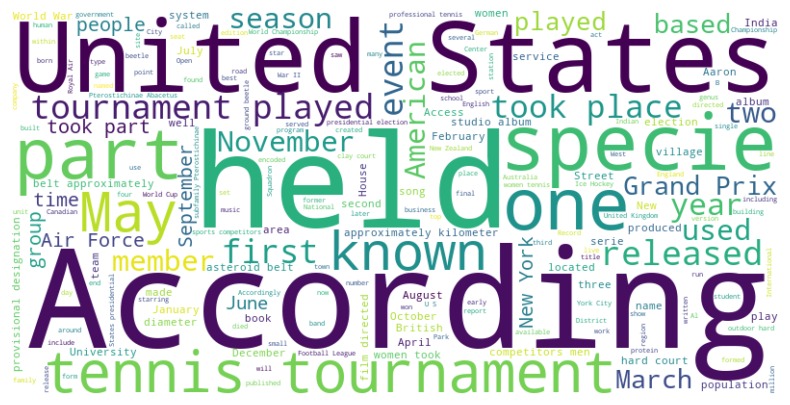

In [3]:
# Visualize data with a word cloud to see most common words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## 3. Prepare Data

In [4]:
# Sample of data before
print(data[:1000])

# Step 1: Split the text into sentences
sentences = sent_tokenize(data)

# Step 2: Remove punctuation from each sentence using a compiled regular expression
punctuation_re = re.compile(r'[^\w\s]')
sentences = [punctuation_re.sub('', sentence) for sentence in sentences]

# Sample of data after removing punctuation and splitting into sentences
print(sentences[:10])

# Step 3: Convert each sentence into a sequence of integers using Keras tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)  # Fit on the entire dataset at once
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(sentences)  # Convert each sentence into a sequence of integers
# preview the first 10 sequences
print(sequences[:10])

0.000123, which corresponds to a distance of 705 Mly, or 216 Mpc.
000webhost is a free web hosting service, operated by Hostinger.
0010x0010 is a Dutch-born audiovisual artist, currently living in Los Angeles.
0-0-1-3 is an alcohol abuse prevention program developed in 2004 at Francis E. Warren Air Force Base based on research by the National Institute on Alcohol Abuse and Alcoholism regarding binge drinking in college students.
0.01 is the debut studio album of H3llb3nt, released on February 20, 1996 by Fifth Colvmn Records.
001 of 3 February 1997, which was signed between the Government of the Republic of Rwanda, and FAPADER.
003230 is a South Korean food manufacturer.
0.04%Gas molecules in soil are in continuous thermal motion according to the kinetic theory of gasses, there is also collision between molecules - a random walk.
0.04% of the votes were invalid.
005.1999.06 is the fifth studio album by the South Korean singer and actress Uhm Jung-hwa.
005 is a 1981 arcade game by Sega.

## 4. Create Features and Labels

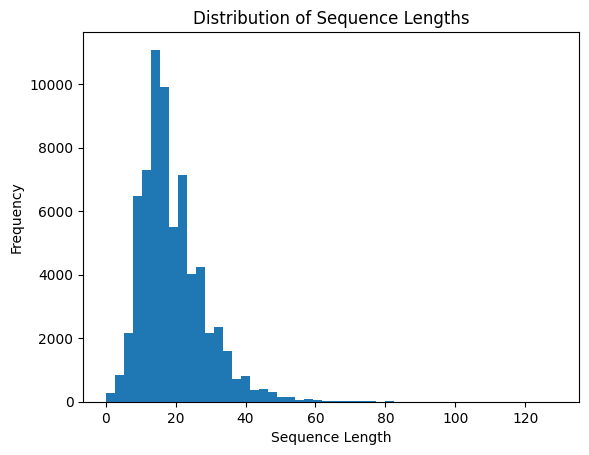

Adjusted max sequence length: 75

First 10 input-output pairs (before padding):
Input sequence: [35254], Output word: 22
Input sequence: [35254    22], Output word: 12036
Input sequence: [35254    22 12036], Output word: 9
Input sequence: [35254    22 12036     9], Output word: 3
Input sequence: [35254    22 12036     9     3], Output word: 1579
Input sequence: [35254    22 12036     9     3  1579], Output word: 4
Input sequence: [35254    22 12036     9     3  1579     4], Output word: 18750
Input sequence: [35254    22 12036     9     3  1579     4 18750], Output word: 35255
Input sequence: [35254    22 12036     9     3  1579     4 18750 35255], Output word: 19
Input sequence: [35254    22 12036     9     3  1579     4 18750 35255    19], Output word: 8600
Shape of X after padding: (5054200, 74)
Shape of X_small: (10000, 74)
Shape of y_small: (10000,)
Vocabulary size: 86656
One-hot encoding completed
Shape of X_train: (8000, 74)
Shape of X_test: (2000, 74)


In [5]:
# Check the distribution of sequence lengths
sequence_lengths = [len(seq) for seq in sequences]
plt.hist(sequence_lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

# Set a reasonable max sequence length based on the distribution
max_sequence_len = min(max(sequence_lengths), 75)  # Use 50 as a reasonable length
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_len, padding='post')
print(f"Adjusted max sequence length: {max_sequence_len}")

# Ensure that the sequences and labels are correctly aligned
X = []
y = []

for sentence in padded_sequences:
    for i in range(1, len(sentence)):
        X.append(sentence[:i])
        y.append(sentence[i])

# Print first 10 input sequences and output words (before padding)
print("\nFirst 10 input-output pairs (before padding):")
for i in range(min(10, len(X))):
    print(f"Input sequence: {X[i]}, Output word: {y[i]}")

# Pad input sequences
X = pad_sequences(X, maxlen=max_sequence_len - 1, padding='post')
print(f"Shape of X after padding: {X.shape}")

# Reduce the size of the dataset for testing
X_small = X[:10000]
y_small = y[:10000]
# Convert y_small to a numpy array
y_small = np.array(y_small)
print(f"Shape of X_small: {X_small.shape}")
print(f"Shape of y_small: {y_small.shape}")

# Convert output words to one-hot encoding
vocab_size = len(word_index) + 1
print(f"Vocabulary size: {vocab_size}")
y_small = to_categorical(y_small, num_classes=vocab_size)
print("One-hot encoding completed")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, test_size=0.2, random_state=42)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

## 5. Build Model

In [6]:
# Import bidirectional LSTM model
from tensorflow.keras.layers import Bidirectional
# Import EarlyStopping and ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load GloVe embeddings
embedding_index = {}
glove_path = 'glove.42B.300d.txt'
if not os.path.exists(glove_path):
    print(
        f"File {glove_path} not found. Please download it from https://nlp.stanford.edu/projects/glove/ and place it in the current directory.")
else:
    with open(glove_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = coefs

    print(f"Loaded {len(embedding_index)} word vectors.")

    # Create an embedding matrix
    embedding_dim = 300
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    # Build the model
    model = Sequential([
        Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_len - 1,
                  trainable=False),
        LSTM(128, return_sequences=True),
        Dropout(0.3),  # Increased dropout rate
        LSTM(128),
        Dropout(0.3),  # Increased dropout rate
        Dense(128, activation='relu'),
        Dropout(0.3),  # Increased dropout rate
        Dense(vocab_size, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=20,  # Increased number of epochs
        batch_size=64,  # Reduced batch size
        validation_split=0.2,
        verbose=1
    )


    def sample_with_temperature(preds, temperature=1.0):
        preds = np.asarray(preds).astype("float64")
        preds = np.log(preds + 1e-10) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        probas = np.random.multinomial(1, preds, 1)
        return np.argmax(probas)


    def predict_next_word(text, num_words=5, temperature=1.4):
        sequence = tokenizer.texts_to_sequences([text])[0]
        generated_text = []

        for _ in range(num_words):
            padded = pad_sequences([sequence], maxlen=max_sequence_len - 1, padding='pre')

            # Predict the next word probabilities and sample with temperature
            pred = model.predict(padded, verbose=0)[0]
            next_word_idx = sample_with_temperature(pred, temperature)

            # If padding token or no valid next word, break the loop
            if next_word_idx == 0:
                break

            # Append predicted word to sequence and generated text
            sequence.append(next_word_idx)
            generated_text.append(tokenizer.index_word.get(next_word_idx, ""))

        # Convert indices back to words
        predicted_text = []
        for idx in sequence[len(sequence) - num_words:]:
            for word, index in word_index.items():
                if index == idx:
                    predicted_text.append(word)
                    break

        return " ".join(predicted_text)


    # Testing the function
    test_sentences = ["The quick brown", "Artificial intelligence is", "In the year", "Learning to code"]
    for test_sentence in test_sentences:
        completed_text = predict_next_word(test_sentence, num_words=10)  # Try generating 10 words
        print(f"Original: {test_sentence}")
        print(f"Completed: {test_sentence} {completed_text}")


    # Enhanced Evaluation Function
    def evaluate_model():
        loss, accuracy = model.evaluate(X_test, y_test, verbose=1)  # Set verbose=1 for detailed output
        print(f"\nTest Loss: {loss:.4f}")
        print(f"Test Accuracy: {accuracy:.4f}")

    # Run enhanced evaluation
    evaluate_model()


Loaded 1917494 word vectors.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-11-02 13:25:53.706618: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-11-02 13:25:53.706829: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-11-02 13:25:53.706835: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-11-02 13:25:53.707362: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-02 13:25:53.708883: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus 

Epoch 1/20


2024-11-02 13:25:59.139125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - accuracy: 0.7416 - loss: 6.9189 - val_accuracy: 0.7794 - val_loss: 2.4843
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.7834 - loss: 2.2198 - val_accuracy: 0.7794 - val_loss: 2.4867
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.7799 - loss: 2.1195 - val_accuracy: 0.7794 - val_loss: 2.4970
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.7867 - loss: 1.9582 - val_accuracy: 0.7794 - val_loss: 2.5609
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.7891 - loss: 1.8970 - val_accuracy: 0.7794 - val_loss: 2.5943
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.7877 - loss: 1.9338 - val_accuracy: 0.7794 - val_loss: 2.6189
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.7788 - loss: 1.9657 - val_accuracy: 0.7794 - val_loss: 2.6352
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.7840 - loss: 1.9129 - val_accurac